[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana9/2_FINBERT_Entrenamiento.ipynb)

# Instalaciones

In [ ]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 7.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 5.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


# FinBERT

En esta clase, mejoraremos lo hecho en la clase anterior (una regresión logística multiclase para clasificación de sentimiento)

Esto se hará utilizando un modelo BERT con ligeros cambios, ha sido entrenado refinadamente para tomar en cuenta términos financieros y posteriormente compararemos los resultados con la regresión.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ver todos los módulos instalados y sus versiones
!pip list

Package                       Version
----------------------------- ----------------------
absl-py                       1.4.0
aeppl                         0.0.33
aesara                        2.7.9
aiohttp                       3.8.3
aiosignal                     1.3.1
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
appdirs                       1.4.4
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.2.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.11.0
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        6.0.0
blis                          0.7.9
bokeh                         2.3.3
branca

In [ ]:
# Info de un módulo en específico
!pip show transformers

Name: transformers
Version: 4.26.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache
Location: /usr/local/lib/python3.8/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, tokenizers, tqdm
Required-by: 


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

In [ ]:
import numpy as np
import pandas as pd 
from transformers import Trainer, TrainingArguments
from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# tested in transformers==4.18.0, pytorch==1.7.1 
import torch
import transformers
torch.__version__, transformers.__version__

('1.13.1+cu116', '4.26.1')

In [ ]:
torch.cuda.is_available()

True

# Predicción con finBERT precargado

In [ ]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

In [ ]:
# Tareas a ejecutar
nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer)

Primer predicción:

In [ ]:
results = nlp('Growth is strong but we do not have liquidity.')  # 'Growth is strong and we have plenty of liquidity.'
print(results)

[{'label': 'Positive', 'score': 0.9999997615814209}]


## ¿Qué significa Tokenizar?

In [ ]:
tokenizer.tokenize('Growth is strong but we do not have liquidity.')

['growth', 'is', 'strong', 'but', 'we', 'do', 'not', 'have', 'liquidity', '.']

## Para que sirven los Tokens?

In [ ]:
tokenizer.convert_tokens_to_ids(['growth', 'is', 'strong', 'but', 'we', 'do', 'not', 'have', 'liquidity', '.'])

[64, 17, 253, 71, 13, 123, 30, 29, 466, 48]

Primer paso al procesar los textos.

In [ ]:
tokenizer('Growth is strong but we do not have liquidity.')['input_ids']

[3, 64, 17, 253, 71, 13, 123, 30, 29, 466, 48, 4]

# Carga de datos

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Cruso-ApsFinancieras/semana10/data/sentiment_data/Sentences_50Agree.txt', sep='.@', names=['text','label'], encoding='latin1', engine='python')
data

,text,label
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive
...,...,...
4841,LONDON MarketWatch -- Share prices ended lower...,negative
4842,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral
4843,Operating profit fell to EUR 35.4 mn from EUR ...,negative
4844,Net sales of the Paper segment decreased to EU...,negative


In [ ]:
data = data.dropna(subset=['text', 'label']) 

In [ ]:
data = data.replace(['negative','neutral','positive'],[0,1,2]) 

In [ ]:
df_train, df_test, = train_test_split(data, stratify=data['label'], test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train, stratify=df_train['label'],test_size=0.1, random_state=42)
print(df_train.shape, df_test.shape, df_val.shape)

(3924, 2) (485, 2) (437, 2)


In [ ]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

## Ejercicio

¿Como se ven los datasets preparados?

Traten de inspeccionar los datos y ver como son

In [ ]:
#@title Antes de preprocesar el objeto Dataset

Dataset.from_pandas(df_train)[0]

{'text': 'Stora Enso will record a capital gain of EUR 33 million as a non-recurring financial item in its fourth quarter 2006 results ',
 'label': 1,
 '__index_level_0__': 886}

In [ ]:
#@title Procesado
dataset_train[0]

{'label': tensor(1),
 'input_ids': tensor([    3,  9220,  2404, 20966,   688,    36,   956,    11,    65,   608,
             7,  5114,  3060,    27,    18,    11,  3159,    85,  2269,    39,
           366,    10,    38,   326,    47,   612,    83,     4,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   

# Configuración para entrenamiento

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy' : accuracy_score(predictions, labels)}

args = TrainingArguments(
        output_dir = 'temp/',
        evaluation_strategy = 'epoch',
        save_strategy = 'epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
)

trainer = Trainer(
        model=finbert,                         # the instantiated 🤗 Transformers model to be trained
        args=args,                  # training arguments, defined above
        train_dataset=dataset_train,         # training dataset
        eval_dataset=dataset_val,            # evaluation dataset
        compute_metrics=compute_metrics
)

In [ ]:
trainer.train()   


The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3924
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 615
  Number of trainable parameters = 109754115


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.433456,0.842105
2,No log,0.388296,0.839817
3,No log,0.410794,0.867277
4,No log,0.458973,0.869565
5,0.424400,0.506774,0.862700


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 437
  Batch size = 32
Saving model checkpoint to temp/checkpoint-123
Configuration saved in temp/checkpoint-123/config.json
Model weights saved in temp/checkpoint-123/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 437
  Batch size = 32
Saving model checkpoint to temp/checkpoint-246
Configuration saved in temp/checkpoint-246/config.json
Mod

TrainOutput(global_step=615, training_loss=0.353934325241461, metrics={'train_runtime': 455.1139, 'train_samples_per_second': 43.11, 'train_steps_per_second': 1.351, 'total_flos': 1290571313955840.0, 'train_loss': 0.353934325241461, 'epoch': 5.0})

Evaluación

In [ ]:
finbert.eval()
trainer.predict(dataset_test).metrics

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 485
  Batch size = 32


{'test_loss': 0.6818954348564148,
 'test_accuracy': 0.8309278350515464,
 'test_runtime': 3.9987,
 'test_samples_per_second': 121.29,
 'test_steps_per_second': 4.001}

In [ ]:
trainer.predict(dataset_test)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 485
  Batch size = 32


PredictionOutput(predictions=array([[-7.5496035,  6.361292 ,  1.5597879],
       [ 5.1295476, -4.5914164, -4.2301273],
       [-4.37057  , -3.466639 ,  7.303799 ],
       ...,
       [ 2.179485 , -5.2438774, -0.8167486],
       [-6.167914 ,  8.187986 , -2.4130874],
       [-2.2701447,  3.560782 , -5.6961923]], dtype=float32), label_ids=array([1, 0, 1, 1, 2, 0, 0, 1, 2, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 2, 1, 2, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1,
       1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1, 1, 0, 2, 2, 1,
       0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2, 2, 1,
       1, 1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 1, 2, 2, 2, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1,
       2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 1, 1, 1, 0, 1, 2, 0, 1, 1, 1, 2, 1, 2, 2, 1, 1, 0, 1, 1,
       1, 1, 1, 2, 1, 0, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1,
     

In [ ]:
y_pred = trainer.predict(dataset_test).predictions

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 485
  Batch size = 32


In [ ]:
y_pred

array([[-7.5496035,  6.361292 ,  1.5597879],
       [ 5.1295476, -4.5914164, -4.2301273],
       [-4.37057  , -3.466639 ,  7.303799 ],
       ...,
       [ 2.179485 , -5.2438774, -0.8167486],
       [-6.167914 ,  8.187986 , -2.4130874],
       [-2.2701447,  3.560782 , -5.6961923]], dtype=float32)

In [ ]:
y_pred.argmax(axis=1)

array([1, 0, 2, 1, 2, 2, 0, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 2, 1, 1, 1,
       1, 0, 1, 2, 1, 2, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1,
       1, 1, 1, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1, 1, 0, 1, 2, 2,
       0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1,
       0, 1, 2, 0, 2, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 0, 0, 1, 1, 1, 1, 2,
       1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 1, 1,
       1, 2, 2, 0, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       2, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2, 2, 2, 2, 2, 1, 2, 0, 1, 1,
       2, 1, 1, 2, 1, 0, 1, 1, 0, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1,
       1, 1, 2, 2, 1, 1, 2, 1, 0, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 0, 2,
       1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 2, 0, 1, 2, 1, 1, 1, 0, 2, 1, 1, 0, 1, 0, 2, 1, 2, 2, 2,
       2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
comparativo = df_test.copy()

In [ ]:
comparativo['predicted'] = y_pred.argmax(axis=1)

In [ ]:
comparativo

,text,label,predicted
3905,The solution will be installed in the USA to s...,1,1
2756,"Scanfil , a systems supplier and contract manu...",0,0
469,`` The sale of the oxygen measurement business...,1,2
3300,The number of magazine and newspaper readers r...,1,1
3024,Martela said plans to expand its recycled furn...,2,2
...,...,...,...
3445,Vacon recently announced plans to build its No...,1,1
1331,"Sanoma also has an Executive Committee , in ac...",1,1
4073,"The operating loss amounted to EUR 0.8 mn , co...",0,0
1394,"The Lemminkainen Group , headquartered in Hels...",1,1


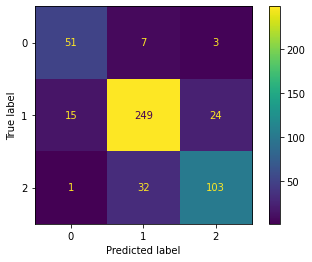

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import log_loss
ConfusionMatrixDisplay.from_predictions(comparativo['label'], comparativo['predicted'])

Guardar el modelo refinado (fine tuned)

In [ ]:
# Ojo, lo guardo en una carpeta que se borrará, es su decisión guardarlo en otro lado
trainer.save_model('finbert-sentiment/')

Saving model checkpoint to finbert-sentiment/
Configuration saved in finbert-sentiment/config.json
Model weights saved in finbert-sentiment/pytorch_model.bin


# Método "antiguo": TextBlob

In [ ]:
text = "Later that day Apple said it was revising down its earnings expectations in \
the fourth quarter of 2018, largely because of lower sales and signs of economic weakness in China. \
The news rapidly infected financial markets. Apple’s share price fell by around 7% in after-hours \
trading and the decline was extended to more than 10% when the market opened. The dollar fell \
by 3.7% against the yen in a matter of minutes after the announcement, before rapidly recovering \
some ground. Asian stockmarkets closed down on January 3rd and European ones opened lower. \
Yields on government bonds fell as investors fled to the traditional haven in a market storm."

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
result = pd.DataFrame()

In [ ]:
from textblob import TextBlob

In [ ]:
blob = TextBlob(text)
result['textblob_prediction'] = [sentence.sentiment.polarity for sentence in blob.sentences]
result

,textblob_prediction
0,0.051746
1,0.000000
2,0.500000
3,0.000000
4,-0.051111
5,0.000000


In [ ]:
blob.sentences

[Sentence("Later that day Apple said it was revising down its earnings expectations in the fourth quarter of 2018, largely because of lower sales and signs of economic weakness in China."),
 Sentence("The news rapidly infected financial markets."),
 Sentence("Apple’s share price fell by around 7% in after-hours trading and the decline was extended to more than 10% when the market opened."),
 Sentence("The dollar fell by 3.7% against the yen in a matter of minutes after the announcement, before rapidly recovering some ground."),
 Sentence("Asian stockmarkets closed down on January 3rd and European ones opened lower."),
 Sentence("Yields on government bonds fell as investors fled to the traditional haven in a market storm.")]

In [ ]:
print(f'Average sentiment is %.2f.' % (result.textblob_prediction.mean()))

Average sentiment is 0.08.


Otro ejemplo

In [ ]:
text2 = "Shares in the spin-off of South African e-commerce group Naspers surged more than 25% \
in the first minutes of their market debut in Amsterdam on Wednesday. Bob van Dijk, CEO of \
Naspers and Prosus Group poses at Amsterdam's stock exchange, as Prosus begins trading on the \
Euronext stock exchange in Amsterdam, Netherlands, September 11, 2019. REUTERS/Piroschka van de Wouw \
Prosus comprises Naspers’ global empire of consumer internet assets, with the jewel in the crown a \
31% stake in Chinese tech titan Tencent. There is 'way more demand than is even available, so that’s \
good,' said the CEO of Euronext Amsterdam, Maurice van Tilburg. 'It’s going to be an interesting \
hour of trade after opening this morning.' Euronext had given an indicative price of 58.70 euros \
per share for Prosus, implying a market value of 95.3 billion euros ($105 billion). The shares \
jumped to 76 euros on opening and were trading at 75 euros at 0719 GMT."

In [ ]:
result2 = pd.DataFrame()
blob = TextBlob(text2)
result2['textblob_prediction'] = [sentence.sentiment.polarity for sentence in blob.sentences]

In [ ]:
result2

,textblob_prediction
0,0.250000
1,0.000000
2,0.000000
3,0.533333
4,0.500000
5,0.000000
6,0.000000


In [ ]:
blob.sentences

[Sentence("Shares in the spin-off of South African e-commerce group Naspers surged more than 25% in the first minutes of their market debut in Amsterdam on Wednesday."),
 Sentence("Bob van Dijk, CEO of Naspers and Prosus Group poses at Amsterdam's stock exchange, as Prosus begins trading on the Euronext stock exchange in Amsterdam, Netherlands, September 11, 2019."),
 Sentence("REUTERS/Piroschka van de Wouw Prosus comprises Naspers’ global empire of consumer internet assets, with the jewel in the crown a 31% stake in Chinese tech titan Tencent."),
 Sentence("There is 'way more demand than is even available, so that’s good,' said the CEO of Euronext Amsterdam, Maurice van Tilburg."),
 Sentence("'It’s going to be an interesting hour of trade after opening this morning.'"),
 Sentence("Euronext had given an indicative price of 58.70 euros per share for Prosus, implying a market value of 95.3 billion euros ($105 billion)."),
 Sentence("The shares jumped to 76 euros on opening and were tradi

In [ ]:
print(f'Average sentiment is %.2f.' % (result2.textblob_prediction.mean()))

Average sentiment is 0.18.


# Referencias

- Paper: https://arxiv.org/pdf/1908.10063.pdf
- https://github.com/yya518/FinBERT/blob/master/finetune.ipynb
- https://huggingface.co/yiyanghkust/finbert-tone
- https://www.tensorflow.org/text/tutorials/classify_text_with_bert

Paper con código:
- http://nlp.seas.harvard.edu/annotated-transformer/